In [153]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import src.solver_helper as helper
from src.traffic_world import TrafficWorld
from src.car_plotting_multiple import plot_multiple_cars, plot_cars, animate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
params = {}
params["T"] = 3
params["dt"] = 0.2
params["p_exec"] = 0.4
params["n_lanes"] = 2
params["n_other"] = 4
params["car_density"] = 5000
params["seed"] = 1
params["random_svo"] = 1

i_mpc_start = 0
params["N"] = max(1, int(params["T"] / params["dt"]))

params["number_ctrl_pts_executed"] = max(1, int(np.floor(params["N"] * params["p_exec"])))

### Create the world and vehicle objects
world = TrafficWorld(params["n_lanes"], 0, 999999)

### Create the vehicle placement based on a Poisson distribution
MAX_VELOCITY = 25 * 0.447  # m/s
VEHICLE_LENGTH = 4.5  # m
time_duration_s = (params["n_other"] * 3600.0 /
                   params["car_density"]) * 10  # amount of time to generate traffic
initial_vehicle_positions = helper.poission_positions(params["car_density"],
                                                      int(time_duration_s),
                                                      params["n_lanes"],
                                                      MAX_VELOCITY,
                                                      VEHICLE_LENGTH,
                                                      position_random_seed=params["seed"])
position_list = initial_vehicle_positions[:params["n_other"]]

### Create the SVOs for each vehicle
if params["random_svo"] == 1:
    list_of_svo = [np.random.choice([0, np.pi / 4.0, np.pi / 2.01]) for i in range(params["n_other"])]
else:
    list_of_svo = [params["svo_theta"] for i in range(params["n_other"])]

(ambulance, amb_x0, all_other_vehicles,
 all_other_x0) = helper.initialize_cars_from_positions(params["N"], params["dt"], world, True, position_list,
                                                       list_of_svo)


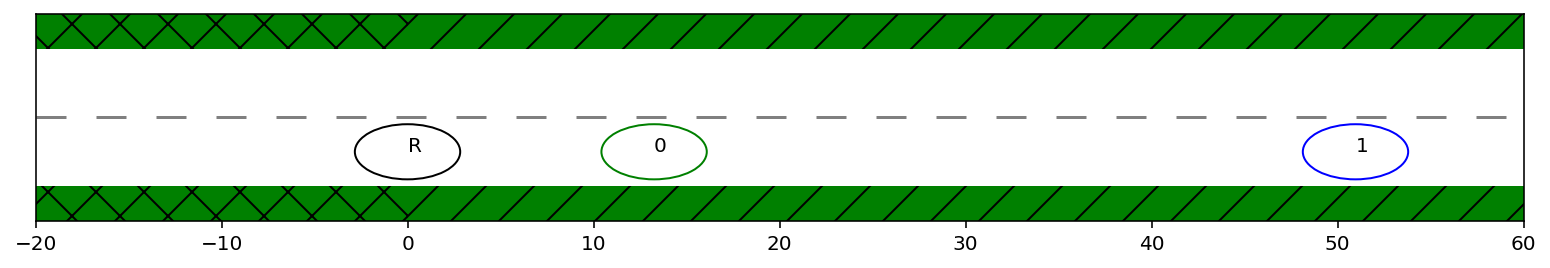

In [155]:
plot_multiple_cars(0, world, ambulance, amb_x0.reshape(6,1), [x.reshape(6,1) for x in all_other_x0], 
          None, car_labels = [str(i) for i in range(len(all_other_x0))])
plt.show()

In [156]:
for i in range(len(all_other_x0)):
    print(i, all_other_x0[i][0:2], )

0 [13.25666717  0.        ]
1 [50.96625915  0.        ]
2 [71.54523846  3.7       ]
3 [81.20876602  0.        ]


In [157]:
lead_veh = helper.get_lead_vehicle(amb_x0, all_other_x0, world)
if lead_veh is None:
    print("Veh Amb, Lead: None")
else:
    print("Veh Amb, Lead %d"%(lead_veh))
for i in range(len(all_other_x0)):
    dummy_x0 = all_other_x0[i] - 10000
    ado_x0s = all_other_x0[:i] + [dummy_x0] + all_other_x0[i+1:]  + [amb_x0]
    lead_veh = helper.get_lead_vehicle(all_other_x0[i], ado_x0s, world)
    if lead_veh is None:
        print("Veh %d, Lead: None"%(i))
    else:
        print("Veh %d, Lead %d"%(i, lead_veh))


Veh Amb, Lead 0
Veh 0, Lead 1
Veh 1, Lead 3
Veh 2, Lead: None
Veh 3, Lead: None


In [158]:
N_total = 300
X_other = [np.zeros((6, N_total+1)) for i in range(len(all_other_vehicles))]
X_amb = np.zeros((6,N_total+1))

X_amb[:,0] = amb_x0
for i in range(len(X_other)):
    X_other[i][:,0] = all_other_x0[i]

    
idm_params = {
    "desired_time_gap": .2,
    "jam_distance": 0.5,
}
# idm_params = None

for t in range(N_total):
    current_other_x0 = [X_other[i][:,t] for i in range(len(X_other))]
    current_amb_x0 = X_amb[:,t]
#     print("Current other:", current_other_x0)
#     print("Current amb:", current_amb_x0)

    # Mobile lane change
    driver_x0 = X_amb[:,t]
    driver_veh = ambulance
    all_other_x0 = current_other_x0
    MOBIL_params = {
        "politeness_factor": 0.1,
    }
    lane, accel = helper.MOBIL_lanechange(driver_x0, driver_veh, all_other_x0, all_other_veh, world, MOBIL_params, idm_params)
    if lane is not None:
#         if t==128:
#             raise Exception("Lane change at t=128")

        print("Lane change at t=%d"%t)
        new_y = world.get_lane_centerline_y(lane)
        X_amb[1,t] = new_y
    current_amb_x0 = X_amb[:, t]

    # Ambulance
    lead_veh = helper.get_lead_vehicle(current_amb_x0, current_other_x0, world)
    if lead_veh is None:
        x_lead = None
        v_lead = None
    else:
        x_lead = current_other_x0[lead_veh]
    X_0 = current_amb_x0
    N=10
    U_ego, X_ego, X_des = helper.IDM_trajectory_prediction(ambulance, N, X_0, x_lead, desired_speed=None, idm_params=idm_params)
    X_amb[:,t+1] = X_ego[:,1]
    

    
    print("Amb", X_amb[:,t+1])
    # Other vehicles
    for ego_idx in range(len(all_other_vehicles)):
        N = 1
                           
    
        # Mobile lane change
        driver_x0 = current_other_x0[ego_idx] 
        driver_veh = all_other_vehicles[ego_idx]
        all_other_x0 = current_other_x0[:ego_idx] + current_other_x0[ego_idx+1:]  + [current_amb_x0]   
        all_other_veh = all_other_vehicles[:ego_idx] + all_other_vehicles[ego_idx+1:]  + [ambulance]    
        
        MOBIL_params = {
            "politeness_factor": 0.1,
        }
        lane, accel = helper.MOBIL_lanechange(driver_x0, driver_veh, all_other_x0, all_other_veh, world, MOBIL_params, idm_params)
        if lane is not None:
            print("Lane change at t=%d"%t)
            new_y = world.get_lane_centerline_y(lane)
            X_other[ego_idx][1,t] = new_y
        current_other_x0[ego_idx] = X_other[ego_idx][:, t]        
        
        
        
        X_0 = current_other_x0[ego_idx]
        dummy_x0 = current_other_x0[ego_idx] - 10000
        ado_x0s = current_other_x0[:ego_idx] + [dummy_x0] + current_other_x0[ego_idx+1:]  + [current_amb_x0]
        lead_veh = helper.get_lead_vehicle(current_other_x0[ego_idx], ado_x0s, world)    

        if lead_veh is None:
            x_lead = None
            v_lead = None
        else:
            x_lead = ado_x0s[lead_veh]


        U_ego, X_ego, X_des = helper.IDM_trajectory_prediction(all_other_vehicles[ego_idx], N, X_0, x_lead, desired_speed=None, idm_params=idm_params)
        
        X_other[ego_idx][:,t+1] = X_ego[:, 1]
        
        

        
        
        
        
        
#         print(ego_idx, X_ego[:,1])

Lane change at t=0
Amb [ 2.25545901  3.7         0.          0.         11.49134008  2.25545901]
newfollower_after 3 -1
8.756667169685779
newfollower_after 3 -1
46.46625915334659
oldfollower_before 0 -1
33.209591983660815
newfollower_after 1 -1
16.078979304757446
oldfollower_before 3 -1
67.04523845810404
newfollower_after 2 -1
5.163527564023724
oldfollower_before 1 -1
25.74250686878117
Amb [ 4.59044733  3.7         0.          0.         11.85854317  4.59044733]
newfollower_after 3 -1
8.716476715613044
newfollower_after 3 -1
46.42571413160574
oldfollower_before 0 -1
33.209237415992696
newfollower_after 1 -1
16.079867637665366
oldfollower_before 3 -1
67.0055817692711
newfollower_after 2 -1
5.163527564023724
oldfollower_before 1 -1
25.74339520168909
Amb [ 6.99308216  3.7         0.          0.         12.16780513  6.99308216]
newfollower_after 3 -1
8.601261664352677
newfollower_after 3 -1
46.30953476698217
oldfollower_before 0 -1
33.20827310262949
newfollower_after 1 -1
16.08228601694891

newfollower_after 3 -1
29.512537252564144
oldfollower_before 0 -1
33.11472145581506
newfollower_after 1 -1
16.322083980899578
oldfollower_before 3 -1
50.33462123346372
newfollower_after 2 -1
5.163527564023752
oldfollower_before 1 -1
25.98561154492333
newfollower_after 0 -1
-0.4498606994782506
Amb [115.87128902   3.7          0.           0.          13.39532656
 115.87128902]
newfollower_after 3 -1
29.062220120647098
oldfollower_before 0 -1
33.11235942116885
newfollower_after 1 -1
16.328258886175945
oldfollower_before 3 -1
49.89047900682304
newfollower_after 2 -1
5.163527564023752
oldfollower_before 1 -1
25.991786450199697
newfollower_after 0 -1
-0.00195602557273844
Amb [118.55032749   3.7          0.           0.          13.39505819
 118.55032749]
newfollower_after 3 -1
28.61195687608135
oldfollower_before 0 -1
33.11000085050861
newfollower_after 1 -1
16.334430868681977
oldfollower_before 3 -1
49.44638774476333
newfollower_after 2 -1
5.163527564023752
oldfollower_before 1 -1
25.99795

oldfollower_before 3 -1
39.25086318008118
newfollower_after 2 -1
5.163527564023752
oldfollower_before 1 -1
26.139115002654762
newfollower_after 0 -1
10.72748670328275
Amb [182.82617205   3.7          0.           0.          13.38532588
 182.82617205]
newfollower_after 3 -1
17.82693709078751
oldfollower_before 0 -1
33.05442379407026
newfollower_after 1 -1
16.48169027645153
oldfollower_before 3 -1
38.80862736723904
newfollower_after 2 -1
5.163527564023752
oldfollower_before 1 -1
26.145217840475283
newfollower_after 0 -1
11.173436125847047
Amb [185.50317763   3.7          0.           0.          13.38472989
 185.50317763]
newfollower_after 3 -1
17.37871437971353
oldfollower_before 0 -1
33.052150505560576
newfollower_after 1 -1
16.487790275027976
oldfollower_before 3 -1
38.366504654741505
newfollower_after 2 -1
5.163527564023752
oldfollower_before 1 -1
26.15131783905173
newfollower_after 0 -1
11.619268937456951
Amb [188.18006185   3.7          0.           0.          13.38411228
 188.18

newfollower_after 0 -1
27.53084824277545
Amb [284.40291313   3.7          0.           0.          13.32978742
 284.40291313]
newfollower_after 3 -1
0.9395191273424075
oldfollower_before 0 -1
32.970367370117856
newfollower_after 1 -1
16.711523864094318
oldfollower_before 3 -1
22.151042991436725
newfollower_after 2 -1
5.1635275640236955
oldfollower_before 1 -1
26.375051428118013
newfollower_after 0 -1
27.965973835046526
Amb [287.06852872   3.7          0.           0.          13.32636847
 287.06852872]
newfollower_after 3 -1
0.5022451646066202
oldfollower_before 0 -1
32.968218999653146
newfollower_after 1 -1
16.717518359293422
oldfollower_before 3 -1
21.719763523900042
newfollower_after 2 -1
5.1635275640236955
oldfollower_before 1 -1
26.381045923317117
newfollower_after 0 -1
28.40043604863439
Amb [289.733439     3.7          0.           0.          13.32273427
 289.733439  ]
newfollower_after 3 -1
0.06563779376415368
oldfollower_before 0 -1
32.96607384239854
newfollower_after 1 -1
16.

oldfollower_before 0 -1
32.83451107832849
newfollower_after 3 -1
6.538525802627362
newfollower_after 2 -1
5.1635275640236955
oldfollower_before 3 -1
16.202053366651057
oldfollower_before 1 -1
6.385280654293467
Amb [387.57502573   0.           0.           0.          13.23451028
 387.57502573]
oldfollower_before 0 -1
32.81738759873133
newfollower_after 3 -1
6.125113115286581
newfollower_after 2 -1
5.1635275640236955
oldfollower_before 3 -1
15.788640679310276
oldfollower_before 1 -1
6.820225155697187
Amb [390.22121548   0.           0.           0.          13.22738717
 390.22121548]
oldfollower_before 0 -1
32.7987132299441
newfollower_after 3 -1
5.712650874649398
newfollower_after 2 -1
5.1635275640236955
oldfollower_before 3 -1
15.376178438673094
oldfollower_before 1 -1
7.254988119680888
Amb [392.86583972   0.           0.           0.          13.21885521
 392.86583972]
oldfollower_before 0 -1
32.778978245064195
newfollower_after 3 -1
5.301461128158735
newfollower_after 2 -1
5.1635275

newfollower_after 2 -1
-3.632761855012575
oldfollower_before 1 -1
18.563265259511752
Amb [490.3433563   0.          0.          0.         11.4262682 490.3433563]
oldfollower_before 0 -1
32.294134419477075
newfollower_after 1 -1
17.696027114524327
newfollower_after 2 -1
5.1635275640236955
oldfollower_before 3 -1
4.29628941903627
newfollower_after 2 -1
-3.579320259612757
oldfollower_before 1 -1
18.628274714500265
Amb [492.62578907   0.           0.           0.          11.3980595
 492.62578907]
oldfollower_before 0 -1
32.28658126682632
newfollower_after 1 -1
17.70759497411302
newfollower_after 2 -1
5.1635275640236955
oldfollower_before 3 -1
4.242847823636453
newfollower_after 2 -1
-3.5318874883458307
oldfollower_before 1 -1
18.687249324563766
Amb [494.90290841   0.           0.           0.          11.37313388
 494.90290841]
oldfollower_before 0 -1
32.279055965226746
newfollower_after 1 -1
17.719136812909596
newfollower_after 2 -1
5.1635275640236955
oldfollower_before 3 -1
4.195415052

newfollower_after 2 -1
5.163527564023411
oldfollower_before 3 -1
3.8101091152886966
newfollower_after 2 -1
-3.1456681354204648
oldfollower_before 1 -1
19.477208241964945
Amb [575.70783     0.          0.          0.         11.1788908 575.70783  ]
oldfollower_before 0 -1
32.021113070291904
newfollower_after 1 -1
18.12287637738541
newfollower_after 2 -1
5.163527564023411
oldfollower_before 3 -1
3.809195699443876
newfollower_after 2 -1
-3.1448465132984893
oldfollower_before 1 -1
19.488981467529356
Amb [577.94356907   0.           0.           0.          11.17849998
 577.94356907]
oldfollower_before 0 -1
32.01424412171218
newfollower_after 1 -1
18.133827980827846
newfollower_after 2 -1
5.163527564023411
oldfollower_before 3 -1
3.8083740773219006
newfollower_after 2 -1
-3.14410743354631
oldfollower_before 1 -1
19.500659639196442
Amb [580.17923392   0.           0.           0.          11.17814852
 580.17923392]
oldfollower_before 0 -1
32.00738942233136
newfollower_after 1 -1
18.144767072

newfollower_after 1 -1
18.572613671947124
newfollower_after 2 -1
5.163527564023411
oldfollower_before 3 -1
3.801103234778566
newfollower_after 2 -1
-3.1375659439056562
oldfollower_before 1 -1
19.94551146288336
Amb [671.82011926   0.           0.           0.          11.17504145
 671.82011926]
oldfollower_before 0 -1
31.738005791306477
newfollower_after 1 -1
18.583077406789016
newfollower_after 2 -1
5.163527564023411
oldfollower_before 3 -1
3.8010935079290675
newfollower_after 2 -1
-3.1375571914575175
oldfollower_before 1 -1
19.955973050779107
Amb [674.05512714   0.           0.           0.          11.1750373
 674.05512714]
oldfollower_before 0 -1
31.731708183045498
newfollower_after 1 -1
18.593530242236625
newfollower_after 2 -1
5.163527564023411
oldfollower_before 3 -1
3.801084755480929
newfollower_after 2 -1
-3.137549315795809
oldfollower_before 1 -1
19.966422891103434
Amb [676.29013422   0.           0.           0.          11.17503356
 676.29013422]
oldfollower_before 0 -1
31.7

In [159]:
temp_folder = "/home/nbuckman/mpc-multiple-vehicles/jupyter_notebooks/temp/"
plot_cars(world, ambulance, X_amb, X_other, temp_folder, "image")

In [160]:
vid_fname = temp_folder + "MOBIL_Egoistic.mp4"
animate(temp_folder, vid_fname, fps=16)

'/home/nbuckman/mpc-multiple-vehicles/jupyter_notebooks/temp/MOBIL_Egoistic.mp4'

In [161]:
from IPython.display import Video

Video(vid_fname, embed=True, width=1024)

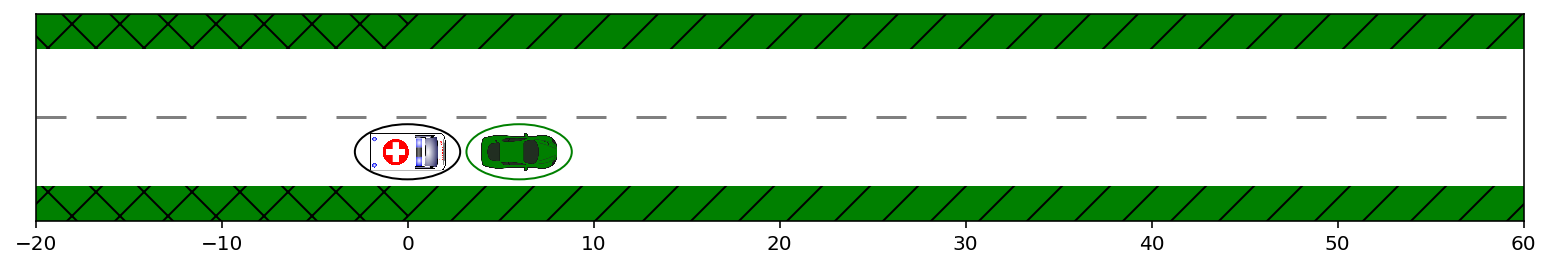

In [78]:
plot_multiple_cars(0, world, ambulance, np.zeros((6,1)), [np.array([[6, 0,0,0,0,0]]).T], 
              None, car_plot_shape = 'both')
plt.show()

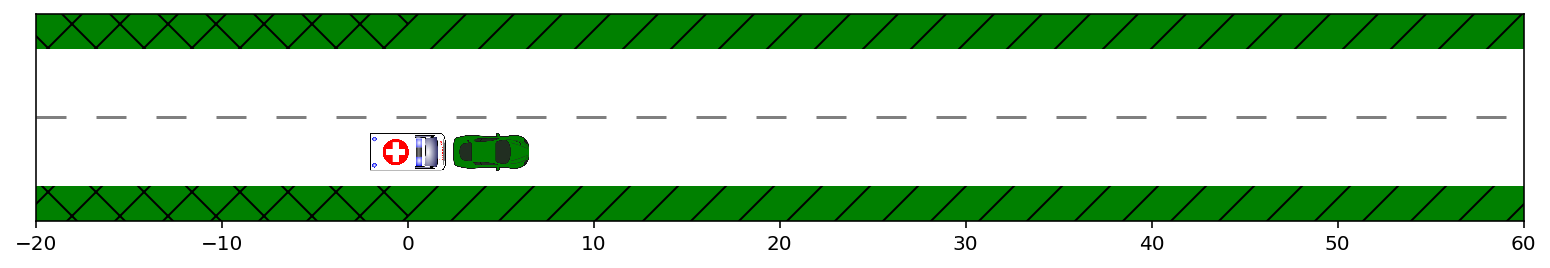

In [80]:
plot_multiple_cars(0, world, ambulance, np.zeros((6,1)), [np.array([[ambulance.L, 0,0,0,0,0]]).T], 
              None, car_plot_shape = 'image')
plt.show()

In [77]:
np.array([[6, 0,0,0,0,0]]).shape

(1, 6)

In [37]:
# driver_idx = 1
# driver_x0 = X_other[driver_idx][:,-1]
# driver_veh = all_other_vehicles[driver_idx]
# all_other_x0 = [X_other[idx][:,-1] for idx in range(1,len(X_other)) if idx!=driver_idx] + [amb_x0]
# all_other_veh = [all_other_vehicles[idx] for idx in range(1,len(X_other)) if idx!=driver_idx] + [ambulance]


In [11]:
driver_x0 = X_amb[:, -1]
driver_veh = ambulance
all_other_x0 = [X_other[idx][:,-1] for idx in range(1,len(X_other))] 
all_other_veh = [all_other_vehicles[idx] for idx in range(1,len(X_other))]


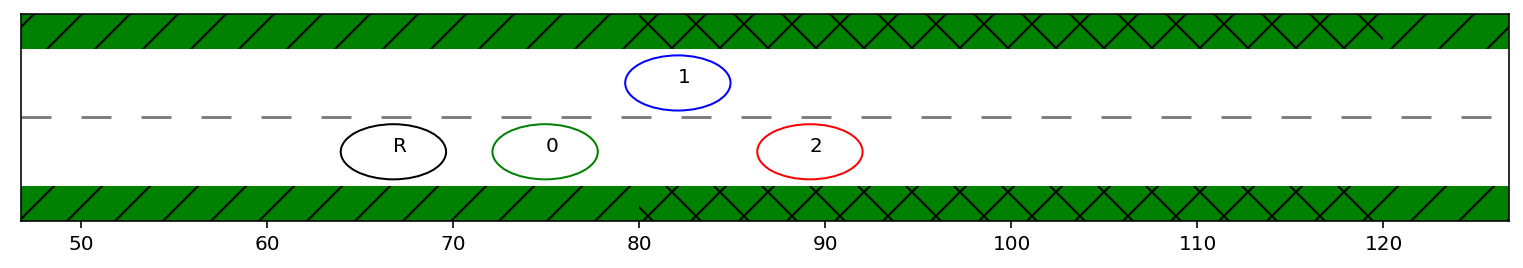

In [12]:
plot_multiple_cars(0, world, ambulance, driver_x0.reshape(6,1), [x.reshape(6,1) for x in all_other_x0], 
          None, car_labels = [str(i) for i in range(len(all_other_x0))])
plt.show()

In [13]:

MOBIL_params = {}

lane, accel = helper.MOBIL_lanechange(driver_x0, driver_veh, all_other_x0, all_other_veh, world, MOBIL_params, idm_params)


In [14]:
lane

1

In [15]:
lane

1

In [16]:
accel

{'newfollower_after': 0,
 'newfollower_before': 0,
 'oldfollower_before': 0,
 'oldfollower_after': 0,
 'driver_after': 1.9643811984959898,
 'driver_before': -0.00483398550666303}

In [30]:
default_MOBIL_params = {
    "politeness_factor": 0.5,
    "changing_threshold": 0.1,
    "maximum_safe_deceleration": 4,
    "bias_for_right_lane": 0.3
}
if MOBIL_params:
    for param in MOBIL_params:
        try:
            default_MOBIL_params[param] = MOBIL_params[param]
        except KeyError:
            raise Exception("Key Error:  Check if MOBIL Param is correct")

p = default_MOBIL_params["politeness_factor"]
a_thr = default_MOBIL_params["changing_threshold"]
b_safe = default_MOBIL_params["maximum_safe_deceleration"]
a_bias = default_MOBIL_params["bias_for_right_lane"]


safety_criteria = accel["newfollower_after"] >= -b_safe

driver_incentive = accel["driver_after"] - accel["driver_before"]
new_follower_incentive = accel["newfollower_after"] - accel["newfollower_before"]
old_follower_incentive = accel["oldfollower_after"] - accel["oldfollower_before"]

incentive_criteria = (driver_incentive + p * (new_follower_incentive + old_follower_incentive)) >= (a_thr)

In [22]:
driver_incentive

-101.951467524669

In [29]:
((new_follower_incentive + old_follower_incentive)*p + driver_incentive >= a_thr)

False

In [25]:
a_thr

0.050820531793537405